In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy as sp

import h5py
import warnings
import random
import math

from matplotlib import rcParams
from matplotlib import cm
from statsmodels.stats.multitest import multipletests
from scipy import stats

warnings.filterwarnings('ignore')
%matplotlib inline

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=300)

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['savefig.transparent'] = True

In [3]:
adata = sc.read('./matrix_clustered.h5ad')
adata = adata[adata.obs['sort']=='CD45']

### Plot relative abundances

In [4]:
def make_abundance_plots (adata, anno_groupby = 'pheno',
                          anno_subsets = 'lineage',
                          anno_pointdef = 'patient',
                          save_file = './figures/default.pdf'):

    ## Get number of categories
    labels = adata.obs[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[anno_pointdef].unique()
    n_patients = len(patient_ids)

    ## Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[anno_pointdef] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]
    subset_frac_labeled = patient_phenos.join(subset_frac)
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].astype('category')
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].cat.reorder_categories(labels)
    subset_frac_labeled['FU'] = 'False'
    subset_frac_labeled['FU'][subset_frac_labeled.index.isin(['P18F','P15F','P06F','C2P05F',
                                                              'C2P13F'])] = 'True'
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].astype('category')
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].cat.reorder_categories(labels)

    ## Make boxplots
    pvals = np.empty([n_labels-1,n_subsets])
    plt.figure(figsize=(20,4*math.ceil(n_subsets/5)))
    for i in np.arange(n_subsets):
        cluster_fracs = [[] for i in range(n_labels)]
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        for j in np.arange(n_labels):
            cluster_fracs[j] = subset_frac_labeled[subset_ids[i]][subset_frac_labeled[anno_groupby]==labels[j]].values
        for j in np.arange(n_labels-1):    
            _, pvals[j,i] = stats.ranksums(cluster_fracs[0],cluster_fracs[j+1])
    
        sns.boxplot(x=anno_groupby,y=subset_ids[i], data= subset_frac_labeled, fliersize=0, 
                    width= 0.5, color='white')
        sns.swarmplot(x=anno_groupby, y=subset_ids[i], data= subset_frac_labeled[subset_frac_labeled['FU']=='False'],
                      size=5)
        sns.swarmplot(x=anno_groupby, y=subset_ids[i], data= subset_frac_labeled[subset_frac_labeled['FU']=='True'],
                      color='k', size=5)
        
        plt.xticks(rotation=45)
        plt.xlabel(None)
        plt.grid(False, axis='both')
        _ , pvals[:,i], _ , _ = multipletests(pvals[:,i], method='fdr_bh')
    for i in np.arange(n_subsets):
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        plt.title(str(subset_ids[i])+'\n'+
                 "FDR= "+' '.join(['{:.3f}'.format(x) if x > 0.001 else '<.001' for x in pvals[:,i]]), fontsize=9.5)
    plt.tight_layout()
    plt.savefig(save_file)

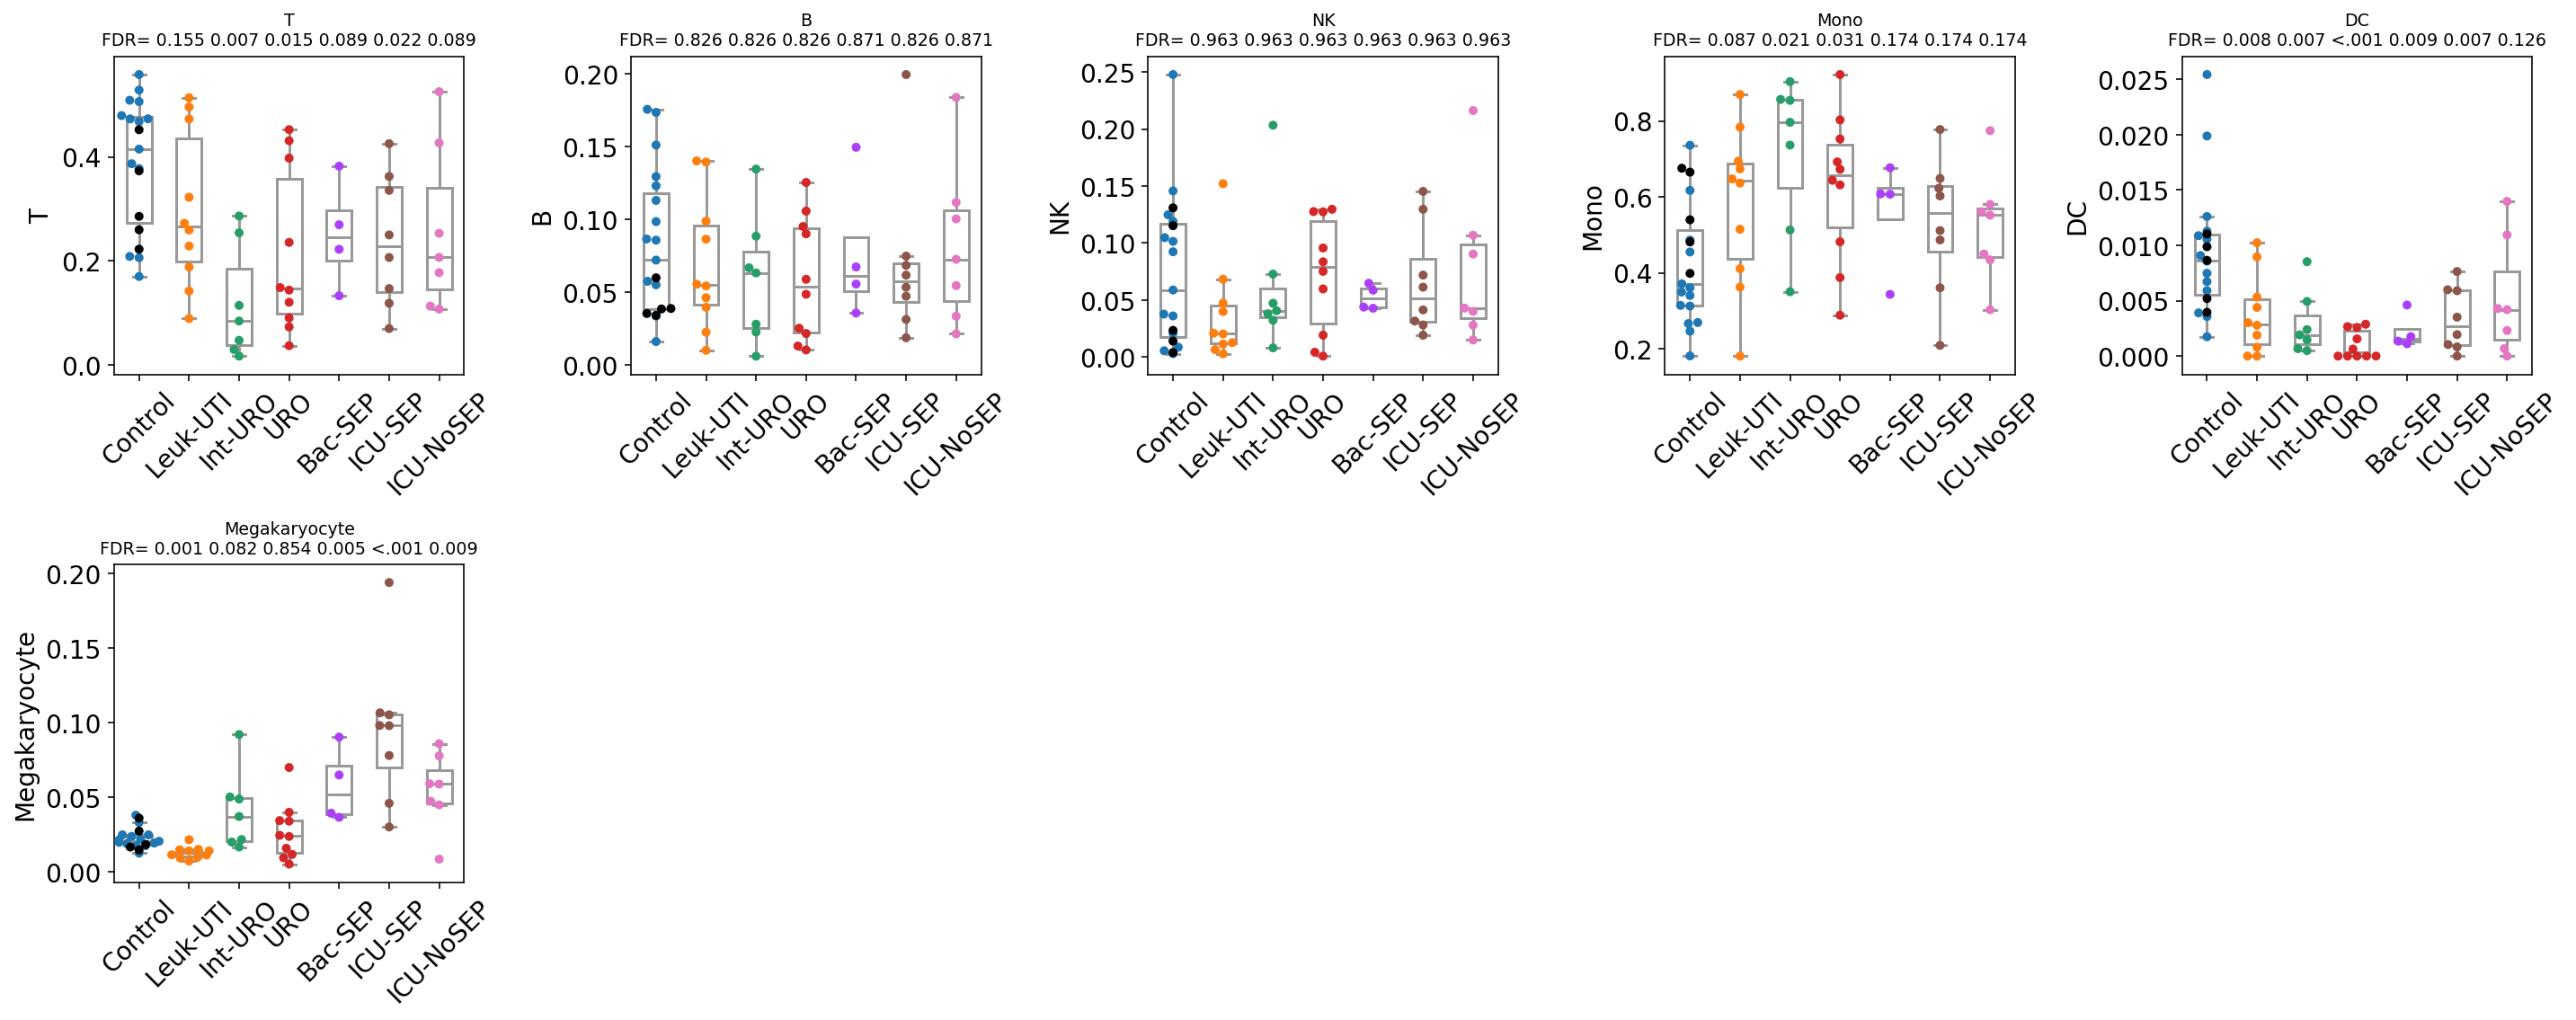

In [5]:
make_abundance_plots(adata,
                     anno_groupby='pheno', anno_subsets='lineage')

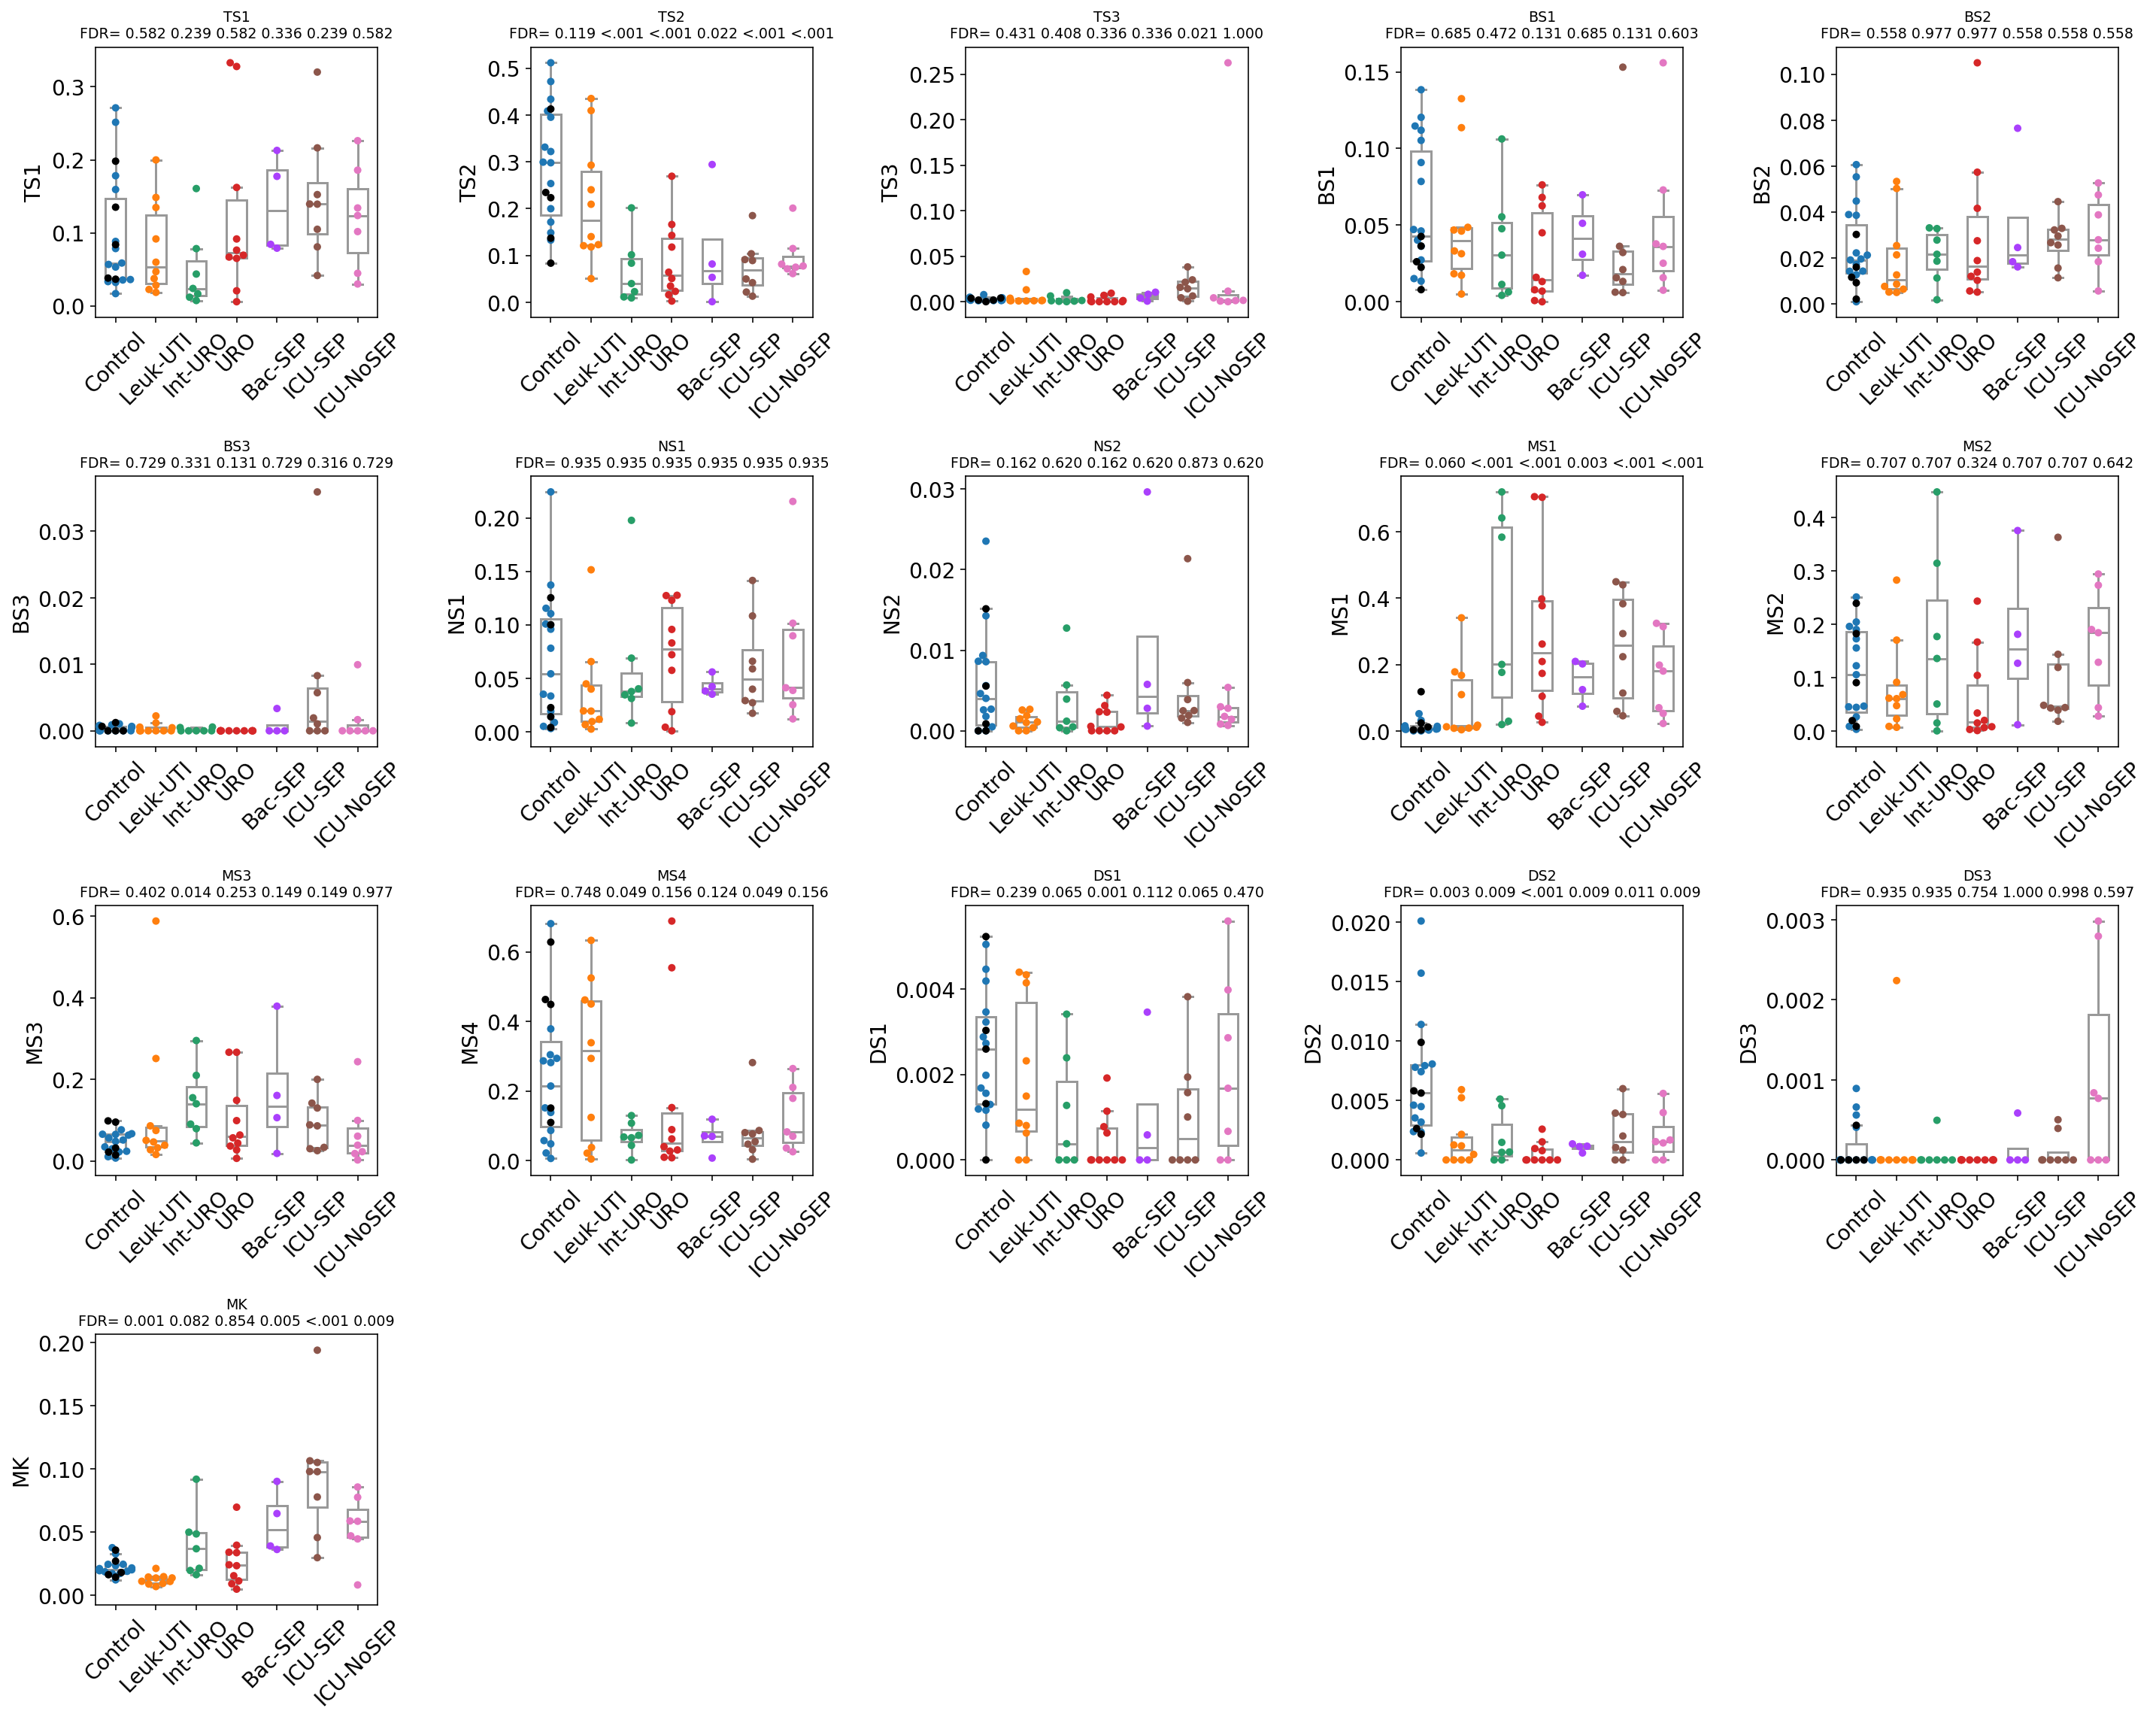

In [6]:
make_abundance_plots(adata,
                     anno_groupby='pheno', anno_subsets='subclusters')

### Plot absolute abundances

In [7]:
def make_absolute_plots (adata, anno_groupby = 'pheno',
                          anno_subsets = 'lineage',
                          anno_pointdef = 'patient',
                          save_file = './figures/default.pdf'):

    ## Get number of categories
    labels = adata.obs[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[anno_pointdef].unique()
    n_patients = len(patient_ids)

    ## Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[anno_pointdef] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]

    subset_frac_labeled = patient_phenos.join(subset_frac)
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].astype('category')
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].cat.reorder_categories(labels)
    subset_frac_labeled = subset_frac_labeled.sort_values(anno_groupby)

    clinical_df = pd.read_csv('./clinical_data.csv', sep=',', header=0)
    clinical_df.index = clinical_df['Patient']
    clinical_df['PBMC'] = clinical_df['WBC']*(clinical_df['Lymph']+clinical_df['Mono'])/100
    subset_frac_labeled = subset_frac_labeled.join(clinical_df['PBMC'])
    subset_frac_labeled = subset_frac_labeled.dropna()

    for i_col in subset_ids:
        subset_frac_labeled[i_col] = subset_frac_labeled[i_col] * subset_frac_labeled['PBMC']
    
    ## Make boxplots
    subset_frac_labeled[anno_groupby] = subset_frac_labeled[anno_groupby].cat.remove_unused_categories()
    labels = subset_frac_labeled[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    
    plt.figure(figsize=(20,4*math.ceil(n_subsets/5)))
    for i in np.arange(n_subsets):
        cluster_fracs = [[] for i in range(n_labels)]
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        for j in np.arange(n_labels):
            cluster_fracs[j] = subset_frac_labeled[subset_ids[i]][subset_frac_labeled[anno_groupby]==labels[j]].values
        cluster_fracs_df = pd.DataFrame(cluster_fracs).transpose()
        cluster_fracs_df.columns = labels
        cluster_fracs_df = cluster_fracs_df.melt(value_vars=labels, value_name='x 10^9 cells/L')
        sns.boxplot(x='variable',y='x 10^9 cells/L',data = cluster_fracs_df, fliersize=0, 
                         width= 0.5, color='white')
        cmap = cm.get_cmap('tab10')
        sns.swarmplot(x="variable", y="x 10^9 cells/L", data=cluster_fracs_df, size=5,
                      palette=[cmap(i+1) for i in range(6)])
        plt.xticks(rotation=45)
        plt.xlabel(None)
        plt.grid(False, axis='both')
    for i in np.arange(n_subsets):
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        plt.title(str(subset_ids[i]))
    plt.tight_layout()
    plt.savefig(save_file)

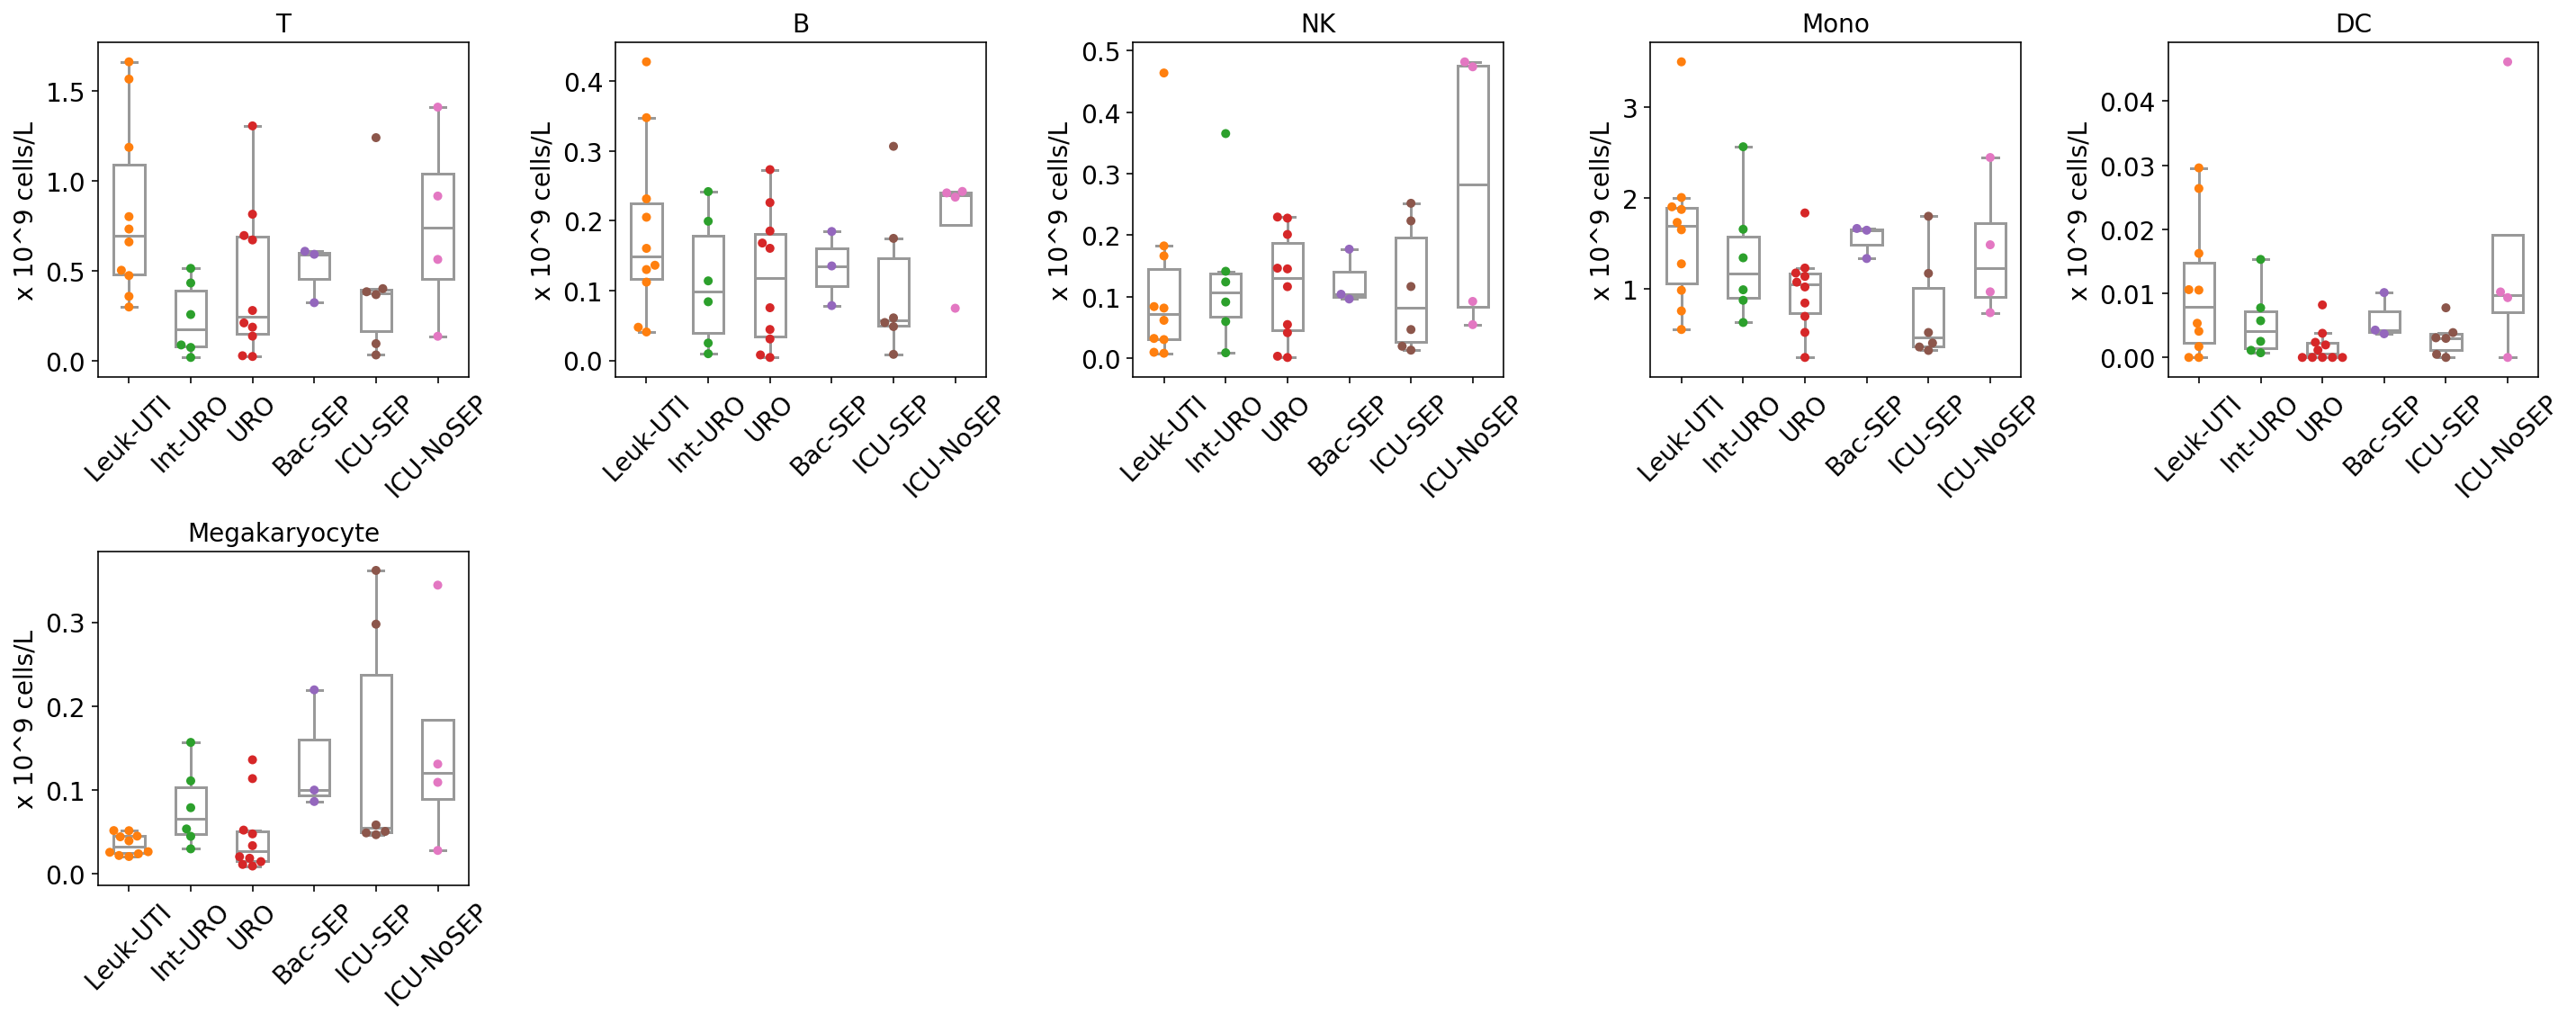

In [8]:
make_absolute_plots(adata)

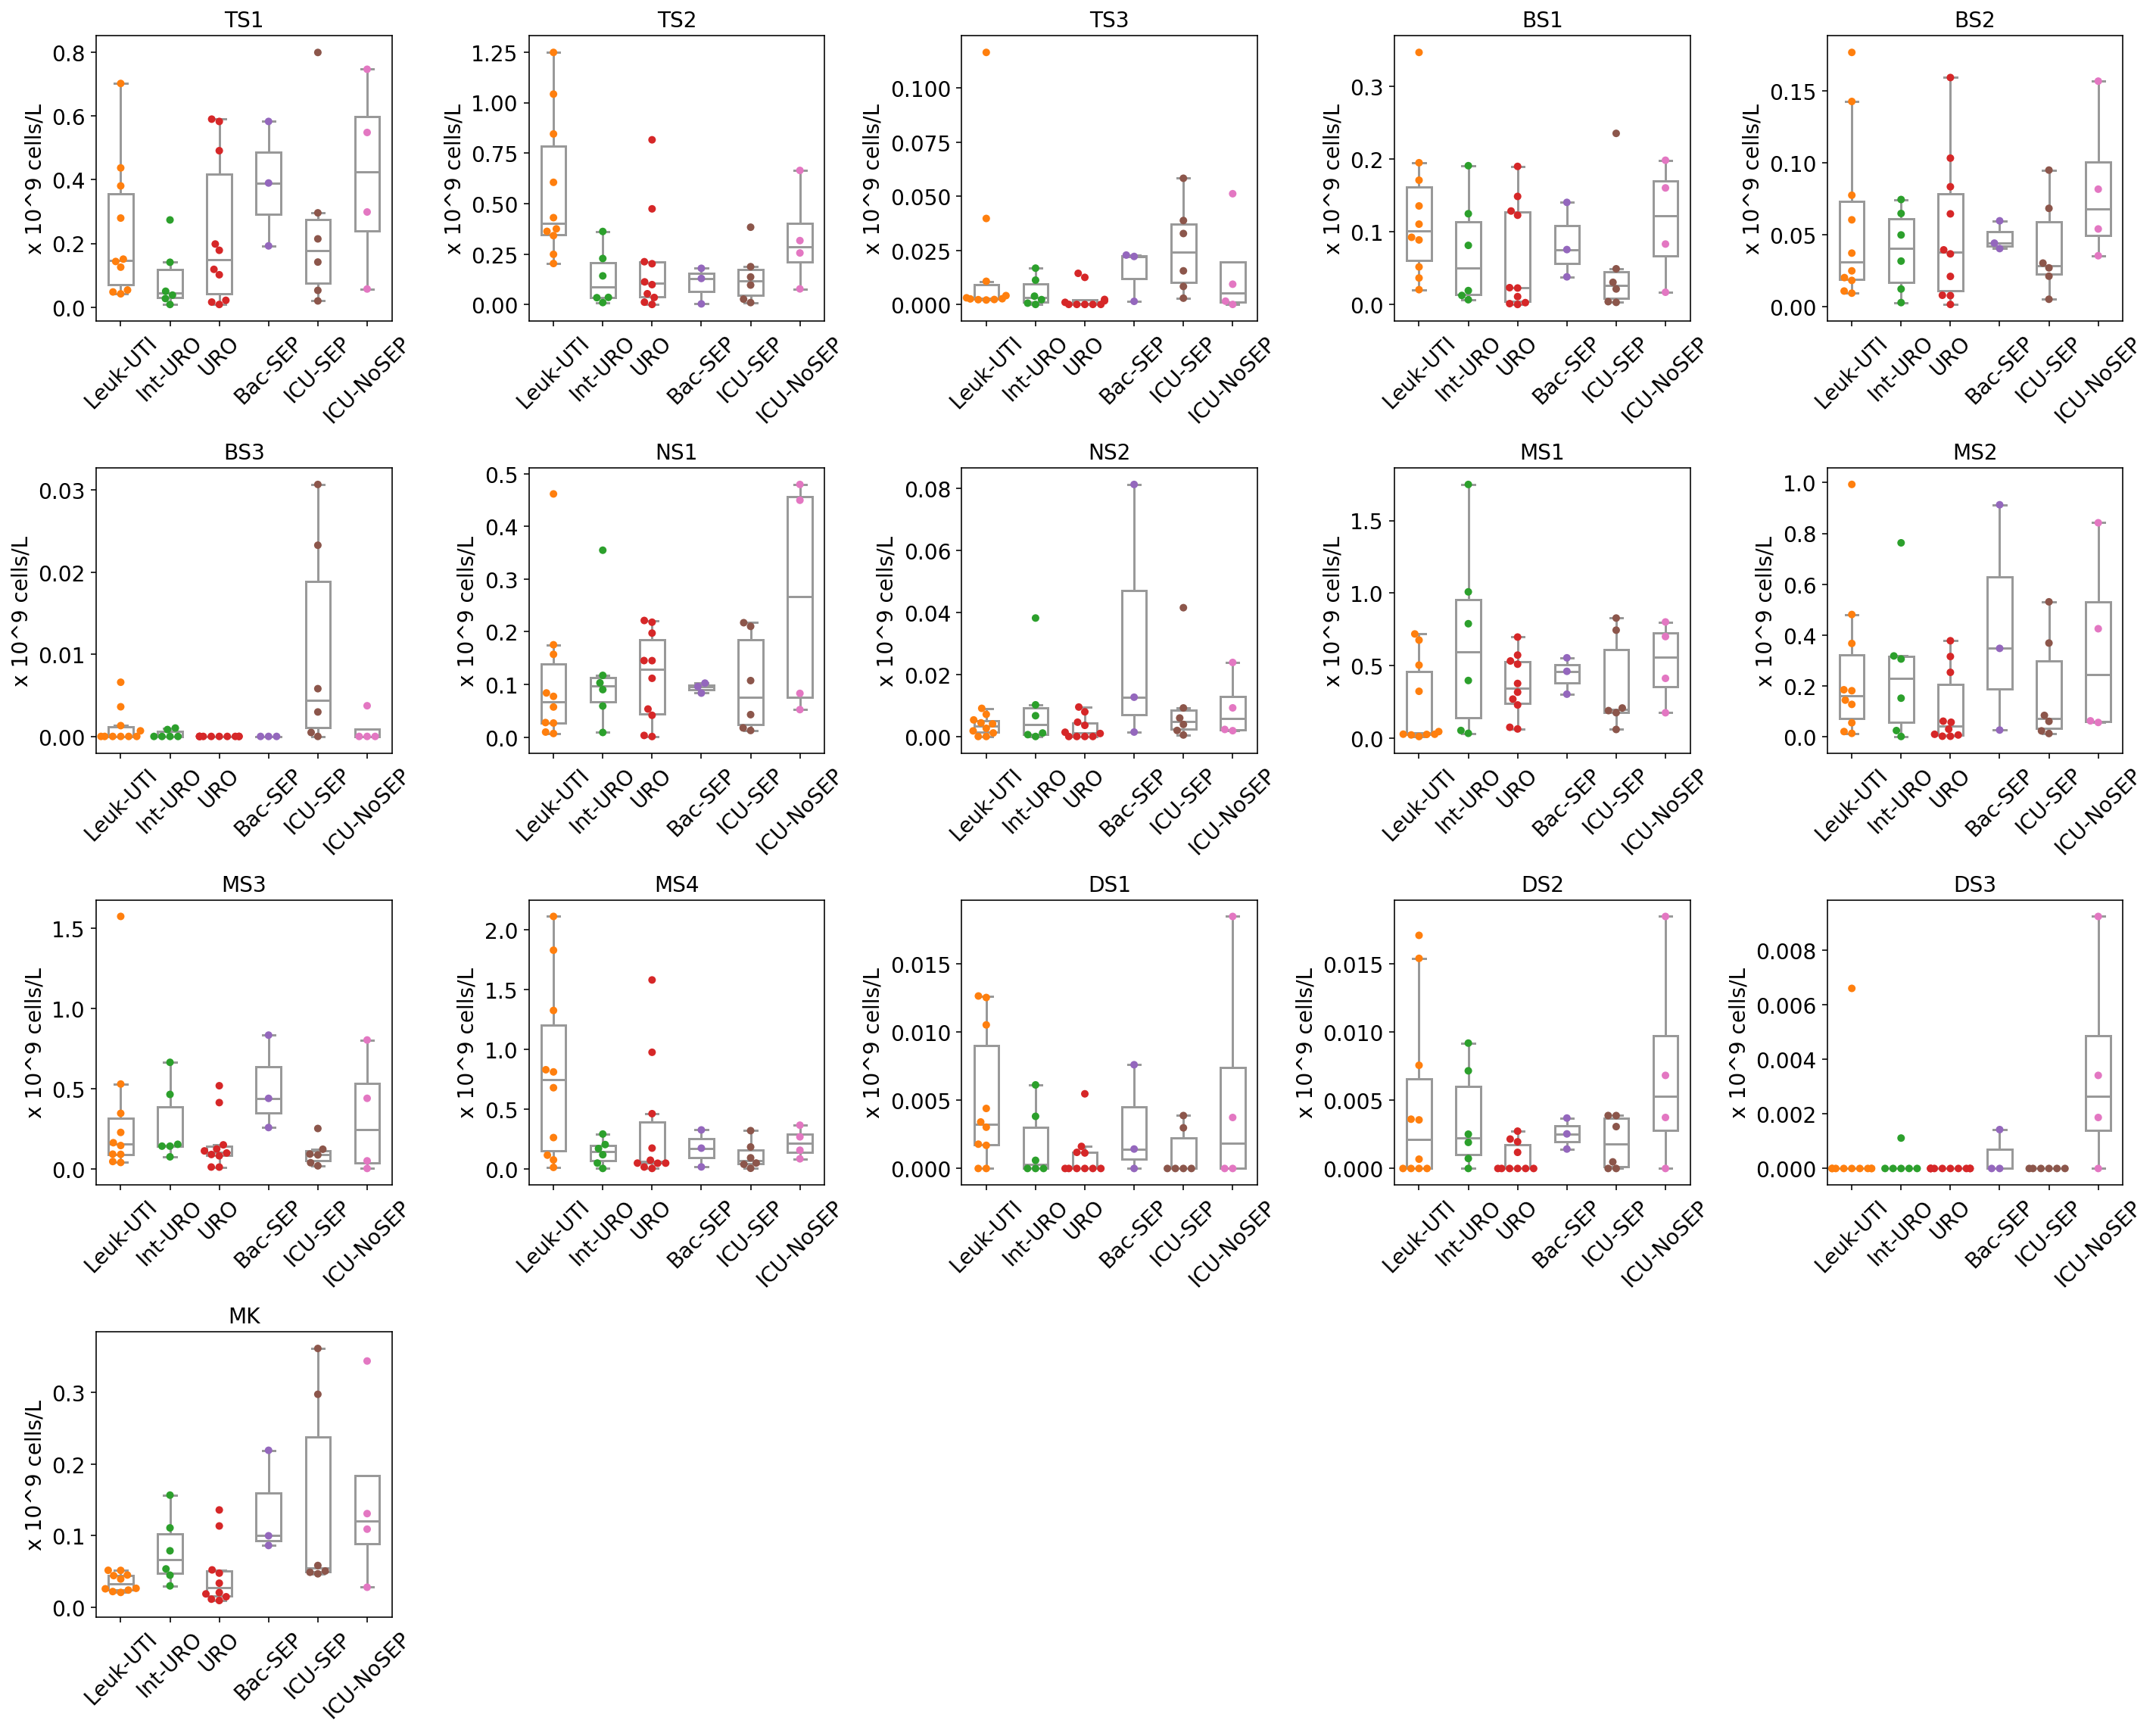

In [9]:
make_absolute_plots(adata, 
                    anno_subsets='subclusters')

### Barplots for each patient

In [10]:
def make_bar_plots (adata, anno_groupby = 'pheno',
                         anno_subsets = 'lineage',
                         anno_pointdef = 'patient',
                         save_file = './figures/default.pdf'):
    
    ## Get number of categories
    labels = adata.obs[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[anno_pointdef].unique()
    n_patients = len(patient_ids)

    ## Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[anno_pointdef] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]
    patient_phenos['pheno'] = patient_phenos['pheno'].astype('category')
    patient_phenos['pheno'] = patient_phenos['pheno'].cat.reorder_categories(labels)
    ord_ind = patient_phenos.sort_values('pheno', ascending=False).index

    subset_frac = subset_frac.loc[ord_ind]

    fig, axes = plt.subplots(1,1, figsize=(9,12))

    subset_frac.plot.barh(stacked=True, grid=False, legend=False, ax=axes)
    axes.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), frameon=False)
    sns.despine(left=True, bottom=True, right=True)
    plt.tight_layout()
    plt.savefig(save_file)

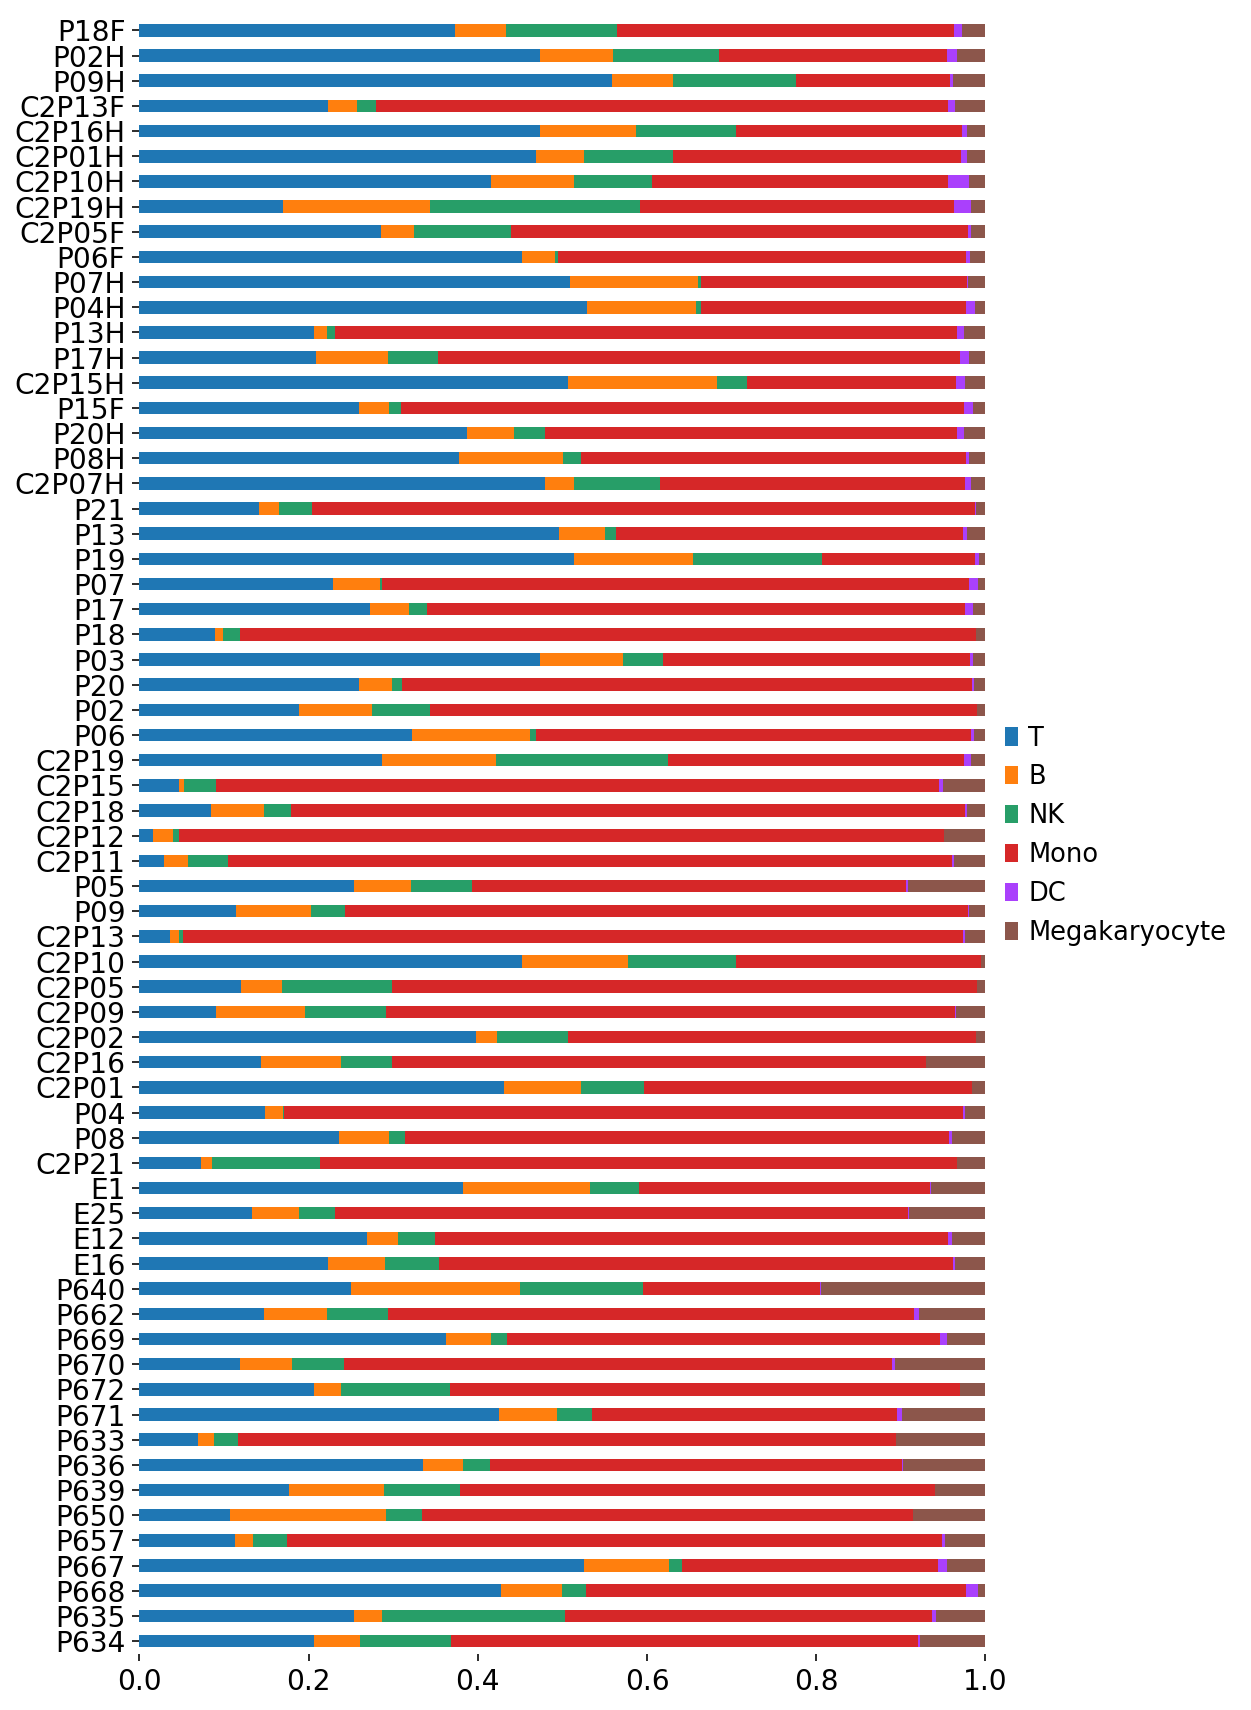

In [11]:
make_bar_plots(adata)

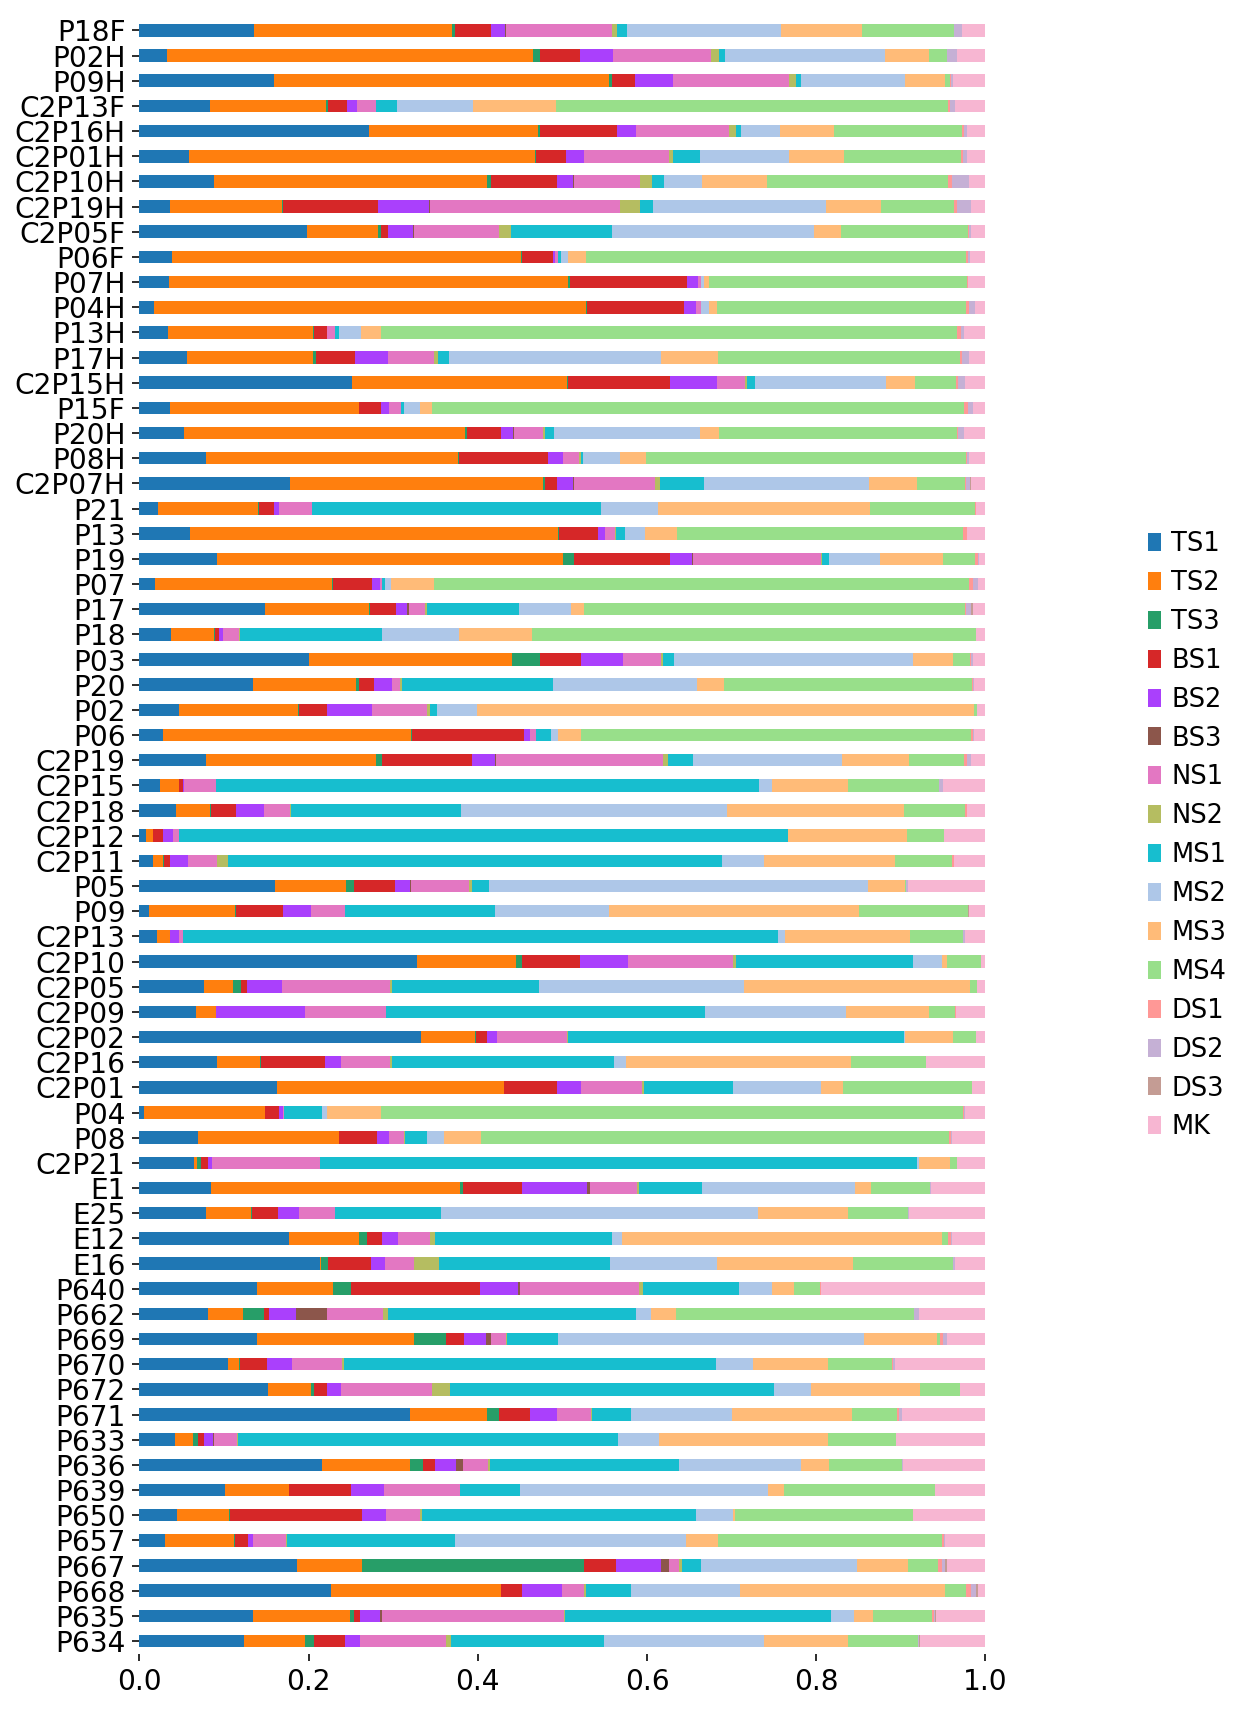

In [12]:
make_bar_plots(adata,
               anno_subsets = 'subclusters')

### Plot correlation matrix among states

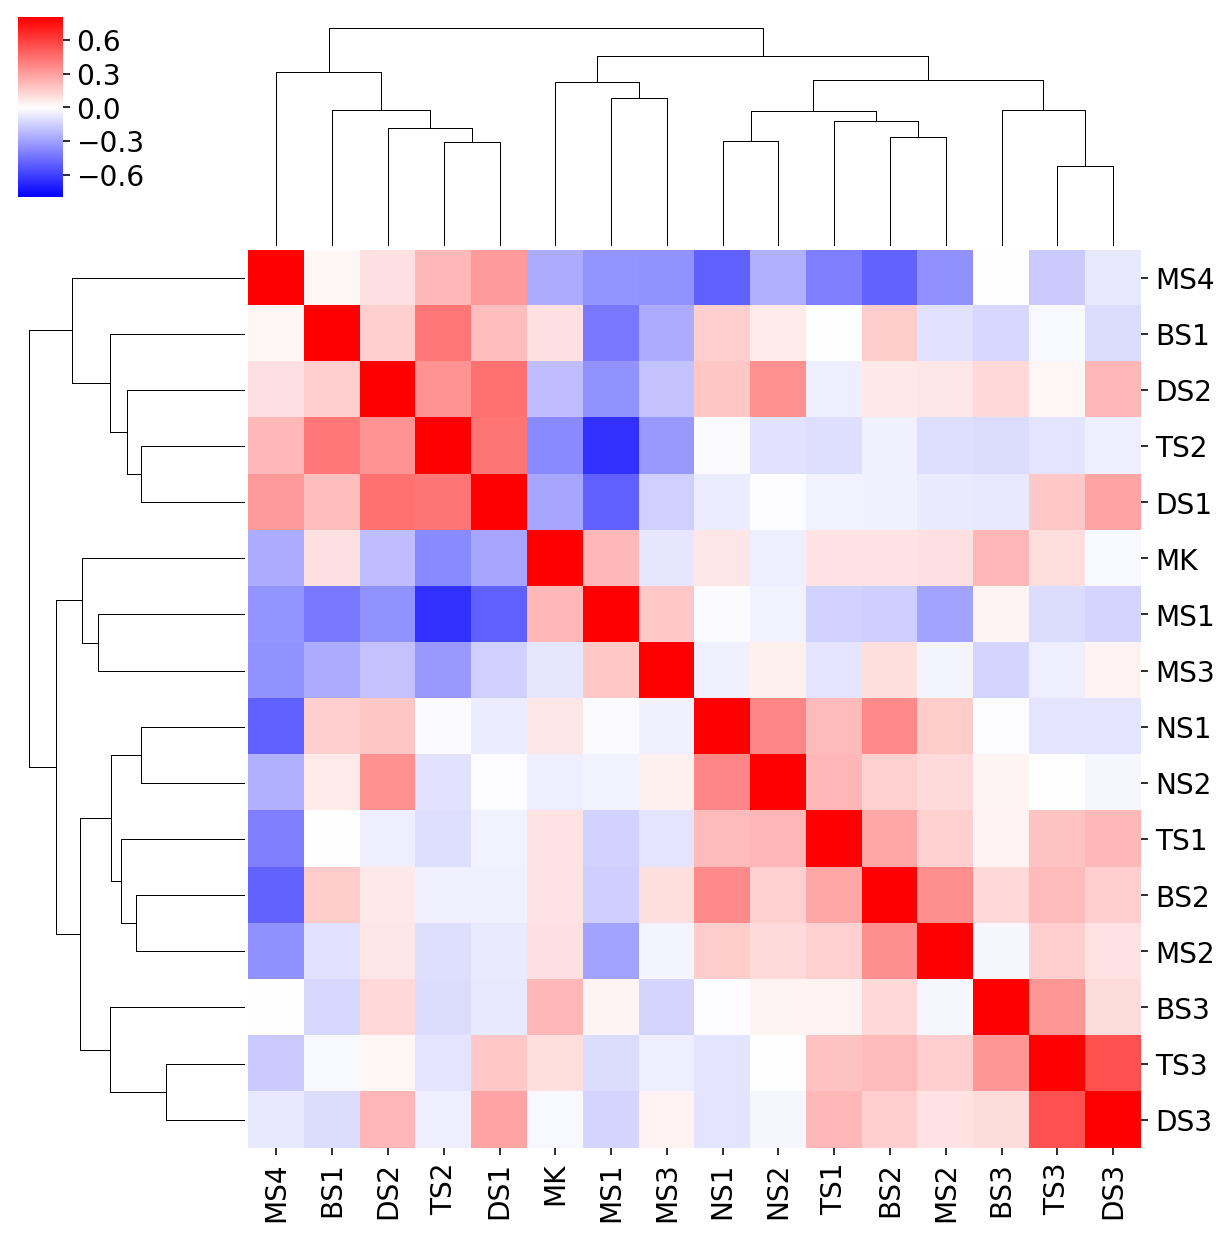

In [13]:
anno_groupby = 'pheno'
anno_subsets = 'subclusters'
anno_pointdef = 'patient'
    
## Get number of categories
labels = adata.obs[anno_groupby].cat.categories.tolist()
n_labels = len(labels)
subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
n_subsets = len(subset_ids)
patient_ids = adata.obs[anno_pointdef].unique()
n_patients = len(patient_ids)

## Calculate subset fractions
subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                index = patient_ids ,
                                columns = subset_ids)
for i in np.arange(n_patients):
    ind2 = adata.obs[anno_pointdef] == patient_ids[i]
    for j in np.arange(n_subsets):
        ind1 = adata.obs[anno_subsets] == subset_ids[j]
        subset_frac.iloc[i,j] = sum(ind1&ind2)
subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

sns.clustermap(subset_frac.corr(method='pearson'), cmap='bwr', vmin=-0.8, vmax=0.8)

### Compare with flow subset abundances

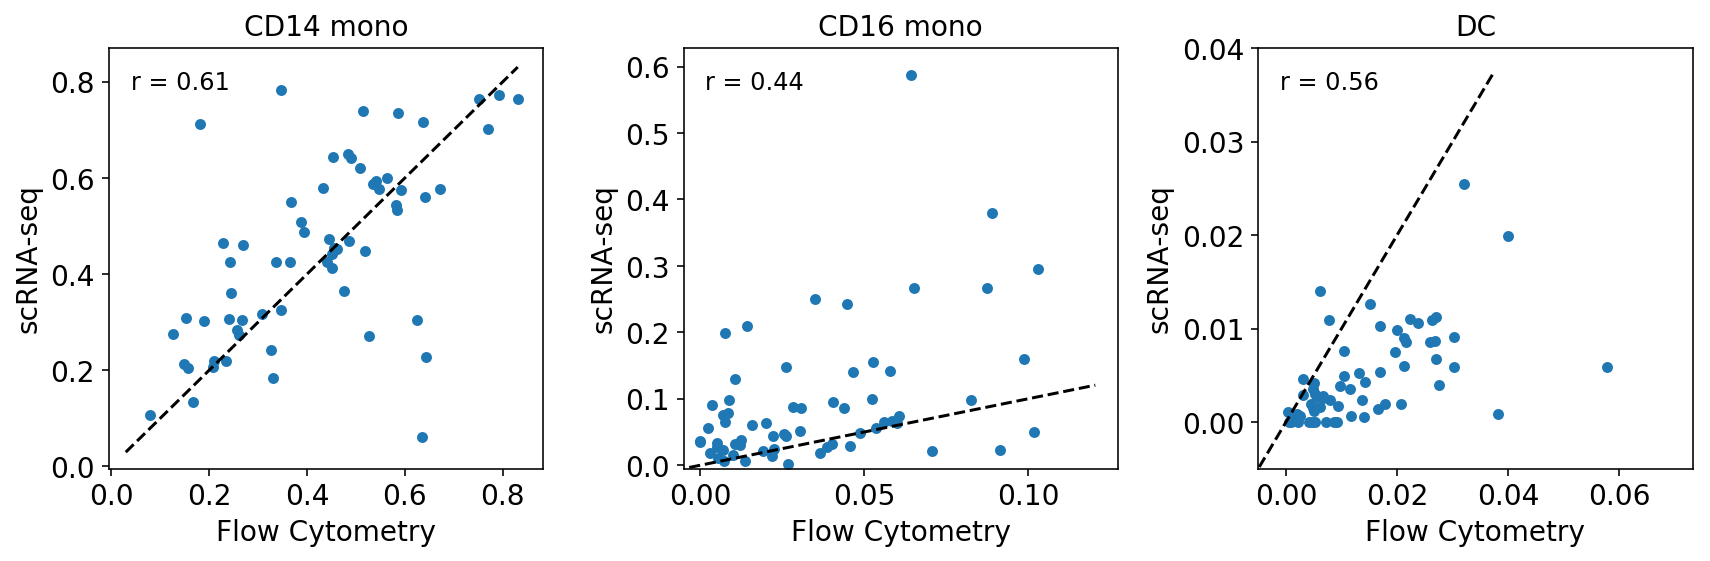

In [14]:
flow_abundance = pd.read_csv('./fc_abundance_table.csv', index_col=0)
flow_abundance = flow_abundance/100

flow_abundance['patient'] = [x.split('-')[0] for x in flow_abundance.index]
flow_abundance['day'] = [x.split('-')[1] for x in flow_abundance.index]
flow_abundance = flow_abundance[flow_abundance['day']=='D0']
flow_abundance.index = [x.split('-')[0] for x in flow_abundance.index]

anno_subsets = 'subclusters'
anno_pointdef = 'patient'

## Get number of categories
subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
n_subsets = len(subset_ids)
patient_ids = adata.obs[anno_pointdef].unique()
n_patients = len(patient_ids)

## Calculate subset fractions
subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                index = patient_ids ,
                                columns = subset_ids)
for i in np.arange(n_patients):
    ind2 = adata.obs[anno_pointdef] == patient_ids[i]
    for j in np.arange(n_subsets):
        ind1 = adata.obs[anno_subsets] == subset_ids[j]
        subset_frac.iloc[i,j] = sum(ind1&ind2)
subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

flow_abundance['CD14 mono - scRNA-seq'] = subset_frac[['MS1','MS2','MS4']].sum(axis=1)
flow_abundance['CD16 mono - scRNA-seq'] = subset_frac[['MS3']]
flow_abundance['DC - scRNA-seq'] = subset_frac[['DS1','DS2','DS3']].sum(axis=1)

flow_abundance = flow_abundance.dropna()

plt.figure(figsize=(12,4))

for i, i_subset in enumerate(['CD14 mono','CD16 mono','DC']): 
    plt.subplot(1,3,i+1)
    plt.scatter(flow_abundance[i_subset],flow_abundance[i_subset+' - scRNA-seq'], s=20)
    plt.gca().plot([max(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0]), 
                    min(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])],
                   [max(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0]), 
                    min(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])],
                   'k--')
    plt.grid(None)
    plt.xlabel('Flow Cytometry'), plt.ylabel('scRNA-seq')
    plt.ylim(bottom=-0.005), plt.xlim(left=-0.005)
    pearson, _ = sp.stats.pearsonr(flow_abundance[i_subset],flow_abundance[i_subset+' - scRNA-seq'])
    plt.text(x=0.05, y=0.9, fontdict={'size':12},
             s= 'r = %.2f' % pearson, 
             transform=plt.gca().transAxes)
    plt.title(i_subset)
    
plt.tight_layout()

### ROC Curve for MS1 vs. Signatures

In [15]:
adata.obs['pheno_combined'] = 'NA'
adata.obs['pheno_combined'][adata.obs['pheno'].isin(['Control','Leuk-UTI'])] = 'CTRL'
adata.obs['pheno_combined'][adata.obs['pheno'].isin(['Int-URO','URO','Bac-SEP','ICU-SEP'])] = 'SEP'

Trying to set attribute `.obs` of view, making a copy.


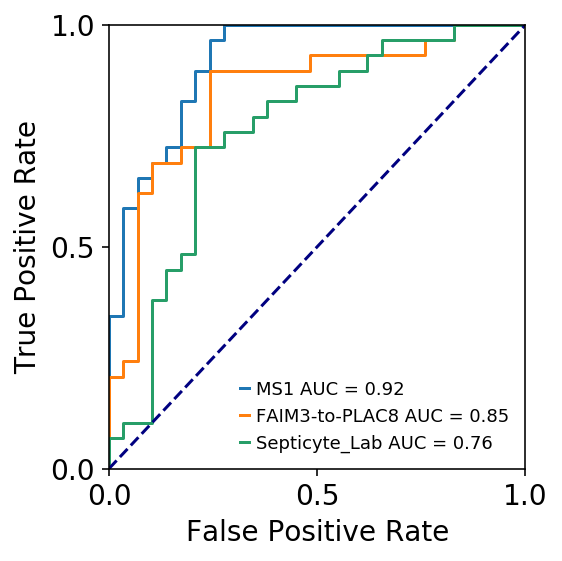

In [16]:
anno_groupby = 'pheno_combined'
anno_pointdef = 'patient'
anno_subsets = 'subclusters'
labels=['CTRL','SEP']

plt.figure (figsize=(4,4))
gs = gridspec.GridSpec(nrows=1,ncols=1)

for predictor in ['MS1','FAIM3-to-PLAC8','Septicyte_Lab']:

    ## Get number of categories
    n_labels = len(labels)
    patient_ids = adata.obs[anno_pointdef].unique()
    n_patients = len(patient_ids)

    if predictor in ['MS1']:
        ## Calculate subset fractions
        subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
        n_subsets = len(subset_ids)
        subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                        index = patient_ids ,
                                        columns = subset_ids)
        for i in np.arange(n_patients):
            ind2 = adata.obs[anno_pointdef] == patient_ids[i]
            for j in np.arange(n_subsets):
                ind1 = adata.obs[anno_subsets] == subset_ids[j]
                subset_frac.iloc[i,j] = sum(ind1&ind2)
        subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)
        pred_vec = subset_frac[predictor]

    else:
        ## Generate pseudobulk tpm matrix
        adata.X = np.expm1(adata.raw.X)
        patient_tpm = np.zeros([len(patient_ids),adata.n_vars])
        for i, i_patient in enumerate(patient_ids):
            patient_matrix = adata[adata.obs[anno_pointdef]==i_patient].X.toarray()
            patient_ss_matrix = patient_matrix[np.random.randint(len(patient_matrix), size=1000), :]
            patient_bulk_ex = np.sum(patient_ss_matrix, axis = 0)
            patient_tpm[i] = (patient_bulk_ex /sum(patient_bulk_ex)*1e6)+1
        tpm_df = pd.DataFrame(patient_tpm, 
                              index = patient_ids, columns = adata.var_names)
        tpm_df = np.log2(tpm_df+1)
        if predictor =='FAIM3-to-PLAC8':
            pred_vec = - (tpm_df['FCMR']/tpm_df['PLAC8'])
        if predictor =='Septicyte_Lab':
            pred_vec = (tpm_df['PLAC8'] + tpm_df['LAMP1']) - (tpm_df['PLA2G7'] + tpm_df['CEACAM4'])
        if predictor =='Sepsis_MetaScore':
            pred_vec = np.power(tpm_df['CEACAM1'] * tpm_df['ZDHHC19'] * tpm_df['NMRK1'] * 
                                tpm_df['GNA15'] * tpm_df['BATF'] * tpm_df['C3AR1'],1/6) - \
                       5/6* np.power(tpm_df['FAM214A'] * tpm_df['TGFB1'] * tpm_df['MTCH1'] * 
                                     tpm_df['RPGRIP1'] * tpm_df['HLA-DPB1'],1/5)

    ## Add patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]

    pred_df = pd.DataFrame(pred_vec)
    pred_df = pred_df.join(patient_phenos)
    pred_df[anno_groupby] = pred_df[anno_groupby].astype('category')
    pred_df[anno_groupby] = pred_df[anno_groupby].cat.reorder_categories(labels)
    pred_df = pred_df.sort_values(anno_groupby)
    pred_df = pred_df.dropna()

    ## Plot ROC curve
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize

    ax = plt.subplot(gs[0,0])
    Y_bin = label_binarize(pred_df[anno_groupby].values, classes=labels)

    sep_roc = roc_curve(Y_bin,pred_df[pred_df.columns[0]], drop_intermediate=True)
    sep_auroc = auc(sep_roc[0], sep_roc[1])
    plt.plot(sep_roc[0],sep_roc[1],
             label= predictor +' AUC = %0.2f' % sep_auroc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0,1]), plt.ylim([0,1])
plt.xticks([0,0.5,1]), plt.yticks([0,0.5,1])
plt.grid(False)
plt.legend(loc='bottom right', frameon=False, prop={'size': 9})
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()

### ROC for MS1 vs. Signatures - SEP vs. ICU-SEP

In [17]:
adata.obs['pheno_combined'] = 'NA'
adata.obs['pheno_combined'][adata.obs['pheno'].isin(['ICU-NoSEP'])] = 'ICU'
adata.obs['pheno_combined'][adata.obs['pheno'].isin(['Int-URO','URO','Bac-SEP','ICU-SEP'])] = 'SEP'
adata = adata[adata.obs['pheno_combined'].isin(['ICU','SEP'])]

Trying to set attribute `.X` of view, making a copy.


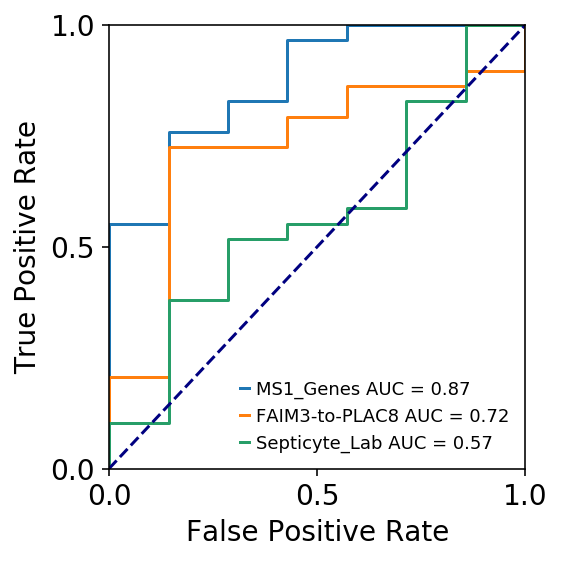

In [18]:
anno_groupby = 'pheno_combined'
anno_pointdef = 'patient'
anno_subsets = 'subclusters'
labels=['ICU','SEP']

plt.figure (figsize=(4,4))
gs = gridspec.GridSpec(nrows=1,ncols=1)

for predictor in ['MS1_Genes','FAIM3-to-PLAC8','Septicyte_Lab']:

    ## Get number of categories
    n_labels = len(labels)
    patient_ids = adata.obs[anno_pointdef].unique()
    n_patients = len(patient_ids)

    if predictor in ['MS1_Genes']:
        ## Generate pseudobulk tpm matrix
        adata_sub = adata[adata.obs['subclusters']=='MS1']
        adata_sub.X = np.expm1(adata_sub.raw.X)
        patient_tpm = np.zeros([len(patient_ids),adata_sub.n_vars])
        for i, i_patient in enumerate(patient_ids):
            patient_matrix = adata_sub[adata_sub.obs[anno_pointdef]==i_patient].X.toarray()
            patient_bulk_ex = np.sum(patient_matrix, axis = 0)
            patient_tpm[i] = (patient_bulk_ex /sum(patient_bulk_ex)*1e6)+1
        tpm_df = pd.DataFrame(patient_tpm, 
                              index = patient_ids, columns = adata_sub.var_names)
        tpm_df = np.log2(tpm_df+1)
        pred_vec = tpm_df['CLU'] * tpm_df['PLAC8']

    else:
        ## Generate pseudobulk tpm matrix
        adata.X = np.expm1(adata.raw.X)
        patient_tpm = np.zeros([len(patient_ids),adata.n_vars])
        for i, i_patient in enumerate(patient_ids):
            patient_matrix = adata[adata.obs[anno_pointdef]==i_patient].X.toarray()
            patient_ss_matrix = patient_matrix[np.random.randint(len(patient_matrix), size=1000), :]
            patient_bulk_ex = np.sum(patient_ss_matrix, axis = 0)
            patient_tpm[i] = (patient_bulk_ex /sum(patient_bulk_ex)*1e6)+1
        tpm_df = pd.DataFrame(patient_tpm, 
                              index = patient_ids, columns = adata.var_names)
        tpm_df = np.log2(tpm_df+1)
        if predictor =='FAIM3-to-PLAC8':
            pred_vec = - (tpm_df['FCMR']/tpm_df['PLAC8'])
        if predictor =='Septicyte_Lab':
            pred_vec = (tpm_df['PLAC8'] + tpm_df['LAMP1']) - (tpm_df['PLA2G7'] + tpm_df['CEACAM4'])
        if predictor =='Sepsis_MetaScore':
            pred_vec = np.power(tpm_df['CEACAM1'] * tpm_df['ZDHHC19'] * tpm_df['NMRK1'] * 
                                tpm_df['GNA15'] * tpm_df['BATF'] * tpm_df['C3AR1'],1/6) - \
                       5/6* np.power(tpm_df['FAM214A'] * tpm_df['TGFB1'] * tpm_df['MTCH1'] * 
                                     tpm_df['RPGRIP1'] * tpm_df['HLA-DPB1'],1/5)

    ## Add patient labels
    patient_phenos = pd.DataFrame(index = patient_ids, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]

    pred_df = pd.DataFrame(pred_vec)
    pred_df = pred_df.join(patient_phenos)
    pred_df[anno_groupby] = pred_df[anno_groupby].astype('category')
    pred_df[anno_groupby] = pred_df[anno_groupby].cat.reorder_categories(labels)
    pred_df = pred_df.sort_values(anno_groupby)
    pred_df = pred_df.dropna()

    ## Plot ROC curve
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize

    ax = plt.subplot(gs[0,0])
    Y_bin = label_binarize(pred_df[anno_groupby].values, classes=labels)

    sep_roc = roc_curve(Y_bin,pred_df[pred_df.columns[0]], drop_intermediate=False)
    sep_auroc = auc(sep_roc[0], sep_roc[1])
    plt.plot(sep_roc[0],sep_roc[1],
             label= predictor +' AUC = %0.2f' % sep_auroc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0,1]), plt.ylim([0,1])
plt.xticks([0,0.5,1]), plt.yticks([0,0.5,1])
plt.grid(False)
plt.legend(loc='bottom right', frameon=False, prop={'size': 9})
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()